# Registration and comparison of Drosophila neurons

This document is an inplementation of Greg Jefferis paper [*Comprehensive Maps of Drosophila Higher Olfactory Centers: Spatially Segregated Fruit and Pheromone Representation*](https://www.cell.com/cell/fulltext/S0092-8674(07)00204-8)

Brains with a type of visual projection neuron (VPN) labeled. We want to test if silencing olfactory projection neurons may alter the projections or VPNs. Images are processed by following steps:

1. ChAT channel from a representitive brain is selected as the template for registration. I also tried to use groupwise registation and average registered ChAT images as template. With given sample size (less than 20), it doesn't work as good as select one good brain. The code I used for registration is [here](./registration_code/GL_warp_batch_emma.sh) 
    - [ ] specify output voxel size in reformatx. 
2. Segmenting neurons. Instead of using actual neuron tracing, we will use thresholding to segment neurons from backgrond. I'm testing the performance of these algorithms:
    a. Otsu's thresholding
    b. Hysteresis thresholding. Hysteresis is better than Otsu if the signal is sparse. - [ ] need to determine what is an optinal way to define the lower threshold. 
    c.How to validate the quality of thresholding? Visually check, within group agreement. 
3. As in the paper, I will use a 3D Gaussian kernel with 2.5 μm standard deviation to generate a smoothed density estimate. 
4. I will perform t-test between conditions for each voxle. Not use if I should downsize the image to reduce the comperison number. The P-value will be adjusted with Turkey's method. 




This notebook will be focusing on developing functions for thresholding and statistical comparison. Actual code will be deploied on great lakes for all data. 

### Example data

control VPNs in nrrd format: ./example_data/VPN/Control/*.nrrd
OPN silent VPNs in nrrd format: ./example_data/VPN/PN_silent/*nrrd

Voxel size: 0.2 x 0.2 x 0.5 micron

In [34]:
# load libaries

import os
import sys
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from skimage import filters
from scipy import ndimage

In [64]:
import numpy as np

# helper functions

def read_nrrd(file_path):
    data, header = nrrd.read(file_path)
    return data, header

def hysteresis_3d_threshold(image_3d, low_threshold=None, high_threshold=None, low_ratio=0.3, high_ratio=0.8):
    """
    Apply Hysteresis thresholding to a 3D image.
    
    Parameters:
    -----------
    image_3d : numpy.ndarray
        3D image array to be thresholded
    low_threshold : float, optional
        Low threshold value. If None, it will be calculated as low_ratio * otsu_threshold
    high_threshold : float, optional
        High threshold value. If None, it will be calculated as high_ratio * otsu_threshold
    low_ratio : float, optional
        Ratio to calculate low threshold if not provided (multiplied by Otsu's threshold)
    high_ratio : float, optional
        Ratio to calculate high threshold if not provided (multiplied by Otsu's threshold)
    
    Returns:
    --------
    binary_image : numpy.ndarray
        Binary image after applying Hysteresis threshold
    thresholds : tuple
        (low_threshold, high_threshold) values used for thresholding
    """
    # Calculate Otsu's threshold as a reference if thresholds are not provided
    otsu_threshold = filters.threshold_otsu(image_3d)
    
    # Set default thresholds if not provided
    if low_threshold is None:
        low_threshold = low_ratio * otsu_threshold
    
    if high_threshold is None:
        high_threshold = high_ratio * otsu_threshold
    
    # Apply hysteresis thresholding
    binary_image = filters.apply_hysteresis_threshold(image_3d, low_threshold, high_threshold)
    
    return binary_image, (low_threshold, high_threshold)


def visualize_segmentation_z_slice(original_image, thresholded_image, z_slice, figsize=(12, 6), fontsize=6):
    """
    Visualize segmentation results by plotting a z-slice from both the original image and thresholded image.
    If z_slice is None, show max projection on x, y, z axes separately.
    
    Parameters:
    -----------
    original_image : numpy.ndarray
        Original 3D image
    thresholded_image : numpy.ndarray
        Binary thresholded 3D image
    z_slice : int or None
        Z-slice number to display, or None for max projections
    figsize : tuple, optional
        Figure size (width, height) in inches
    fontsize : int, optional
        Font size for titles
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the visualization
    """
    import matplotlib.pyplot as plt

    if z_slice is None:
        # Show max projections along each axis
        projections = [
            ('Max Projection (X)', 0),
            ('Max Projection (Y)', 1),
            ('Max Projection (Z)', 2)
        ]
        fig, axes = plt.subplots(2, 3, figsize=(figsize[0], figsize[1]*1.2))
        for i, (title, axis) in enumerate(projections):
            # Original max projection
            orig_proj = np.max(original_image, axis=axis)
            axes[0, i].imshow(orig_proj, cmap='gray')
            axes[0, i].set_title(f'Original {title}', fontsize=fontsize)
            axes[0, i].axis('off')
            # Thresholded max projection
            thresh_proj = np.max(thresholded_image, axis=axis)
            axes[1, i].imshow(thresh_proj, cmap='hot')
            axes[1, i].set_title(f'Thresholded {title}', fontsize=fontsize)
            axes[1, i].axis('off')
        plt.tight_layout()
        return fig

    # Check if z_slice is valid
    if z_slice < 0 or z_slice >= original_image.shape[-1]:
        raise ValueError(f"Z-slice {z_slice} is out of range (0-{original_image.shape[-1]-1})")
    
    # Extract the specified z-slice
    original_slice = original_image[:,:,z_slice] # Assuming the last dimension is z
    thresholded_slice = thresholded_image[:,:,z_slice]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot original image
    axes[0].imshow(original_slice, cmap='gray')
    axes[0].set_title(f'Original Image (Z={z_slice})', fontsize=fontsize)
    axes[0].axis('off')
    
    # Plot thresholded image
    axes[1].imshow(thresholded_slice, cmap='hot')
    axes[1].set_title(f'Thresholded Image (Z={z_slice})', fontsize=fontsize)
    axes[1].axis('off')
    
    # Plot overlay
    overlay = np.zeros((*original_slice.shape, 3))
    original_normalized = original_slice / (original_slice.max() + 1e-8)
    overlay[..., 0] = original_normalized
    overlay[..., 1] = original_normalized
    overlay[..., 2] = original_normalized
    overlay[thresholded_slice > 0, 0] = 1.0  # Red channel
    overlay[thresholded_slice > 0, 1] = 0.0  # Green channel
    overlay[thresholded_slice > 0, 2] = 0.0  # Blue channel
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (Z={z_slice})', fontsize=fontsize)
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig

def Gaussian_filter_3d(image_3d, sigma=2.5, voxel_size=(1.0, 1.0, 1.0)):
    """
    Apply Gaussian filter to a 3D image.
    
    Parameters:
    -----------
    image_3d : numpy.ndarray
        3D image array to be filtered
    sigma (in unit of microns) : float or sequence of floats
        Standard deviation for Gaussian kernel. If a single float is provided,
        it will be used for all axes. If a sequence is provided, it should have
        the same length as the number of dimensions in image_3d.
    voxel_size (in units of microns per voxel): sequence of floats, optional
        Voxel size in each dimension (x, y, z). Used to scale the sigma values.
    
    Returns:
    --------
    filtered_image : numpy.ndarray
        Filtered 3D image (floating point values between 0 and 1)
    """
    # Convert input to float if it's boolean
    if image_3d.dtype == bool:
        image_3d = image_3d.astype(float)
    
    # Convert sigma to voxel units by dividing by voxel size
    if isinstance(sigma, (int, float)):
        # Single sigma value for all dimensions
        voxel_sigma = sigma / np.array(voxel_size)
        print(f"Using single sigma value: {voxel_sigma}")
    else:
        # Sequence of sigma values for each dimension
        voxel_sigma = np.array(sigma) / np.array(voxel_size)
        print(f"Using voxel sigma values: {voxel_sigma}")
    
    # Apply Gaussian filter with different sigma for each dimension
    return ndimage.gaussian_filter(image_3d, sigma=voxel_sigma)

def average_density_maps(folder_path, output_path=None):
    
    # Get all nrrd files in the folder
    nrrd_files = [f for f in os.listdir(folder_path) if f.endswith('.nrrd')]
    print(f"Found {len(nrrd_files)} nrrd files in the folder.")
    if not nrrd_files:
        print("No nrrd files found in the folder.")
        return
    # running average to avoid memory issues
    # initialte by the first file
    first_file = nrrd_files[0]
    first_file_path = os.path.join(folder_path, first_file)
    data, header = read_nrrd(first_file_path)
    data = hysteresis_3d_threshold(data, low_ratio=0.3, high_ratio=0.8)[0]
    data = Gaussian_filter_3d(data, sigma=2.5, voxel_size=(0.2, 0.2, 0.5))
    running_sum = data.astype(np.float32)
    count = 1
    for nrrd_file in nrrd_files[1:]:
        file_path = os.path.join(folder_path, nrrd_file)
        data, header = read_nrrd(file_path)
        data = hysteresis_3d_threshold(data, low_ratio=0.3, high_ratio=0.8)[0]
        data = Gaussian_filter_3d(data, sigma=2.5, voxel_size=(0.2, 0.2, 0.5))
        running_sum += data.astype(np.float32)
        count += 1
    # Calculate the average
    average_data = running_sum / count
    return average_data


In [36]:

test_file = "./example_data/VPN/Control/warp_2025_03_14_64092_MB334C_VT06_GFPcontrol_PNs488_MB334C_568_ChAT_647_Slide2_Animal3_Right_trial2_ch1.nrrd"

if os.path.exists(test_file):
    # Read the image
    image_data, header = read_nrrd(test_file)
    print(f"Image shape: {image_data.shape}")
    
    # Apply Hysteresis thresholding
    hysteresis_binary, (low_thresh, high_thresh) = hysteresis_3d_threshold(image_data)

Image shape: (1024, 1024, 166)


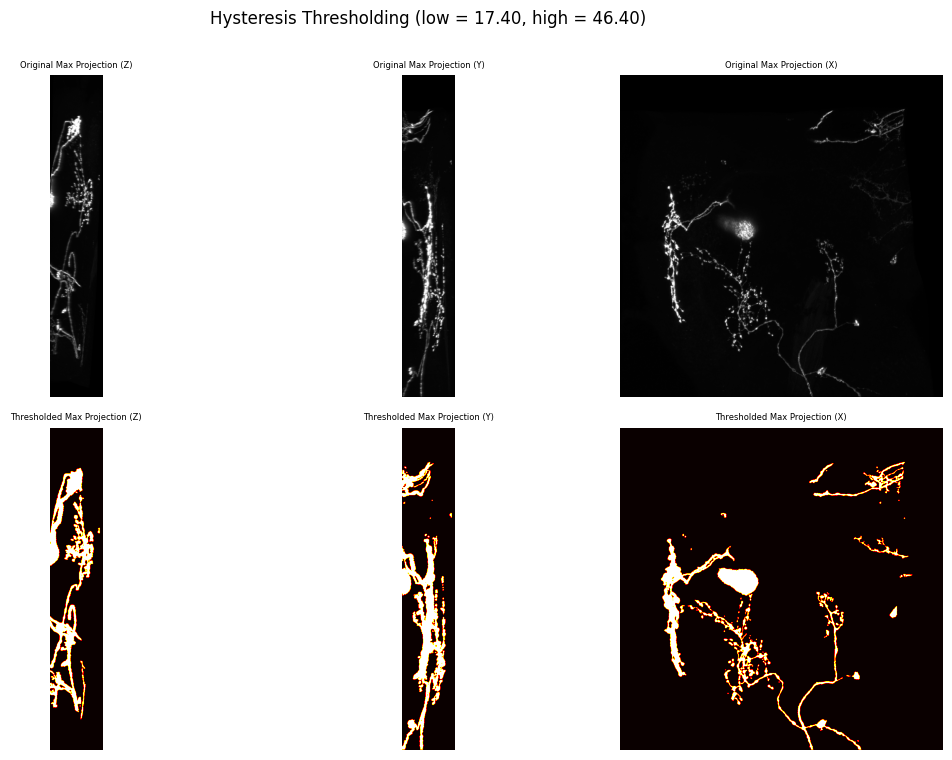

In [44]:

# Find a good z-slice to visualize (middle of the stack)
z = None


# Visualize the Hysteresis segmentation
fig2 = visualize_segmentation_z_slice(image_data, hysteresis_binary, z)
plt.suptitle(f"Hysteresis Thresholding (low = {low_thresh:.2f}, high = {high_thresh:.2f})", 
             x=0.5,    # Horizontal position (0.5 is center, 0 is left, 1 is right)
             y=1.05,   # Vertical position (higher values move it up, lower values move it down)
             fontsize=12)
plt.show()

# # Compare the results
# print(f"Otsu threshold: {otsu_threshold:.4f}")
# print(f"Hysteresis thresholds: Low = {low_thresh:.4f}, High = {high_thresh:.4f}")
# print(f"Percentage of voxels classified as foreground:")
# print(f"  Otsu: {np.mean(otsu_binary) * 100:.2f}%")
# print(f"  Hysteresis: {np.mean(hysteresis_binary) * 100:.2f}%")


In [57]:
# test guassian filter

filtered_image = Gaussian_filter_3d(hysteresis_binary, sigma=2.5, voxel_size=(0.2, 0.2, 0.5))

Using single sigma value: [12.5 12.5  5. ]


In [59]:
# Update visualization function to handle floating-point density maps
def visualize_density_map(original_image, density_map, z_slice=None, figsize=(12, 6), fontsize=6):
    """
    Visualize density map results by plotting slices or projections.
    If z_slice is None, show max projection on x, y, z axes separately.
    
    Parameters:
    -----------
    original_image : numpy.ndarray
        Original 3D image
    density_map : numpy.ndarray
        Floating-point density map (Gaussian filtered binary image)
    z_slice : int or None
        Z-slice number to display, or None for max projections
    figsize : tuple, optional
        Figure size (width, height) in inches
    fontsize : int, optional
        Font size for titles
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the visualization
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    # Create a custom colormap for density (white to red)
    density_cmap = LinearSegmentedColormap.from_list('density', ['white', 'red'])
    
    if z_slice is None:
        # Show max projections along each axis
        projections = [
            ('Max Projection (X)', 0),
            ('Max Projection (Y)', 1),
            ('Max Projection (Z)', 2)
        ]
        fig, axes = plt.subplots(2, 3, figsize=(figsize[0], figsize[1]*1.2))
        for i, (title, axis) in enumerate(projections):
            # Original max projection
            orig_proj = np.max(original_image, axis=axis)
            axes[0, i].imshow(orig_proj, cmap='gray')
            axes[0, i].set_title(f'Original {title}', fontsize=fontsize)
            axes[0, i].axis('off')
            
            # Density map max projection
            density_proj = np.max(density_map, axis=axis)
            axes[1, i].imshow(density_proj, cmap=density_cmap)
            axes[1, i].set_title(f'Density {title}', fontsize=fontsize)
            axes[1, i].axis('off')
        plt.tight_layout()
        return fig

    # For single slice visualization
    # Check if z_slice is valid
    if z_slice < 0 or z_slice >= original_image.shape[-1]:
        raise ValueError(f"Z-slice {z_slice} is out of range (0-{original_image.shape[-1]-1})")
    
    # Extract the specified z-slice
    original_slice = original_image[:,:,z_slice]
    density_slice = density_map[:,:,z_slice]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot original image
    axes[0].imshow(original_slice, cmap='gray')
    axes[0].set_title(f'Original Image (Z={z_slice})', fontsize=fontsize)
    axes[0].axis('off')
    
    # Plot density map
    im = axes[1].imshow(density_slice, cmap=density_cmap)
    axes[1].set_title(f'Density Map (Z={z_slice})', fontsize=fontsize)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], shrink=0.8)
    
    # Plot overlay
    overlay = np.zeros((*original_slice.shape, 3))
    original_normalized = original_slice / (original_slice.max() + 1e-8)
    overlay[..., 0] = original_normalized
    overlay[..., 1] = original_normalized
    overlay[..., 2] = original_normalized
    
    # Add red color based on density (more transparent for lower values)
    for i in range(density_slice.shape[0]):
        for j in range(density_slice.shape[1]):
            if density_slice[i, j] > 0:
                intensity = density_slice[i, j] / density_map.max()
                overlay[i, j, 0] = max(original_normalized[i, j], intensity)  # Red
                overlay[i, j, 1] = original_normalized[i, j] * (1-intensity)  # Green
                overlay[i, j, 2] = original_normalized[i, j] * (1-intensity)  # Blue
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (Z={z_slice})', fontsize=fontsize)
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig

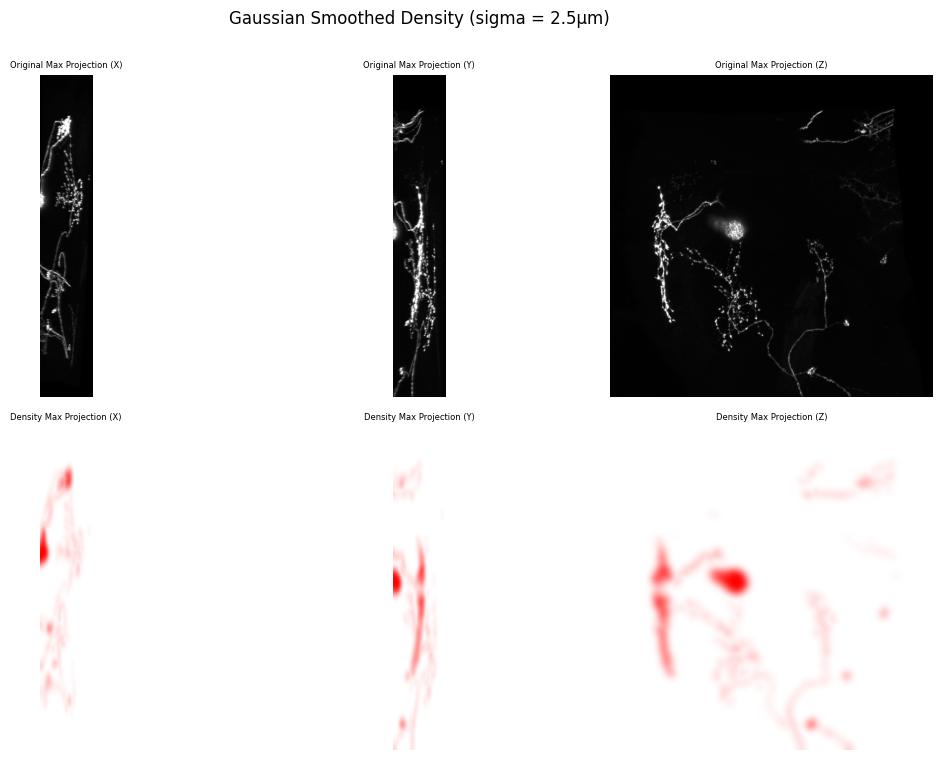

In [60]:
# Visualize the density map
fig3 = visualize_density_map(image_data, filtered_image, z)
plt.suptitle(f"Gaussian Smoothed Density (sigma = 2.5µm)", 
             x=0.5, y=1.05, fontsize=12)
plt.show()

In [65]:
test_folder = "example_data/VPN/Control"

density_map_avg_control = average_density_maps(test_folder)



Found 7 nrrd files in the folder.
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]


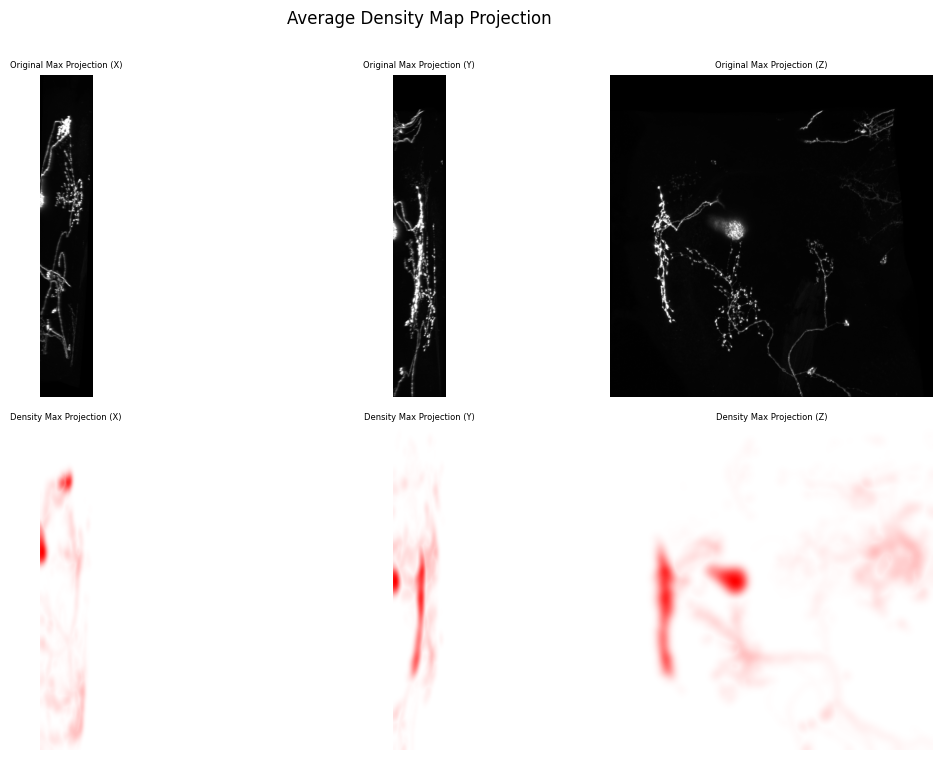

In [66]:
# show the projection of the average density map
fig4 = visualize_density_map(image_data, density_map_avg_control, z)
plt.suptitle(f"Average Density Map Projection", 
             x=0.5, y=1.05, fontsize=12)
plt.show()  

In [67]:
experimental_folder = "example_data/VPN/PN_silent"

density_map_avg_PN_silent = average_density_maps(experimental_folder)

# subtract the average density map from the experimental data
density_map_diff = density_map_avg_PN_silent - density_map_avg_control

# save the density map difference as nrrd file
output_file = "density_map_difference.nrrd"
nrrd.write(output_file, density_map_diff, header)
print(f"Density map difference saved to {output_file}")

Found 8 nrrd files in the folder.
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Using single sigma value: [12.5 12.5  5. ]
Density map difference saved to density_map_difference.nrrd
